# Exercise Session: Logistic Regression
$\renewcommand{\real}{\mathbb{R}}$
$\newcommand{\xb}{\mathbf{x}}$
$\newcommand{\wb}{\mathbf{w}}$
$\newcommand{\Xb}{\mathbf{X}}$
$\newcommand{\yb}{\mathbf{y}}$
$\newcommand{\Yb}{\mathbf{Y}}$
$\DeclareMathOperator*{\argmin}{argmin}$

In [1]:
%load_ext autoreload
%autoreload 2

# project files
import sys
sys.path.append('..')
import helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# 1 Introduction

This week's exercise is about linear classification, in particular, logistic regression. You will see both the binary and the multi-class variant of the logistic regression.

# 2 Binary Class Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). To facilitate visualization, we will only use 2 out of the 4 features of this dataset. Furthermore, we will use 2 out of the 3 classes in this dataset, named *setosa* and *versicolor*. Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 

Note that $\Xb$ is a matrix of shape $(N \times (D+1))$. However, a single data sample $\xb_i$ is a column vector of shape $((D+1) \times 1)$. 
To compute a scalar product of one data sample with the weight vector $\wb$ (also a column vector of shape $((D+1) \times 1)$), we write $\xb_i^\top\cdot\wb$. To perform a matrix-vector multiplication of the entire data matrix with the weight vector, we write $\Xb\cdot\wb$.

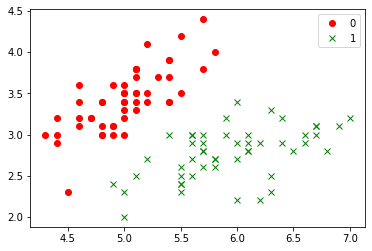

In [2]:
# Loads the data and split them into training and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  

## 2.1 A short introduction

In logistic regression, the probability of a datapoint belonging to a class is found as:
$$P(y_i=1|\xb_i, \wb) = \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}} $$

This is called the sigmoid function! The sigmoid function is defined as:
$$\sigma(t)= \frac{1}{1+e^{-t}}$$

So in our case, our model is defined as:
$$\hat{y}(\xb_i)=\sigma(\xb_i^{\top}\cdot \wb)= \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}}$$



Let's try to code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [3]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in [0, 1].
    """
    return 1/(1 + np.exp(-t))

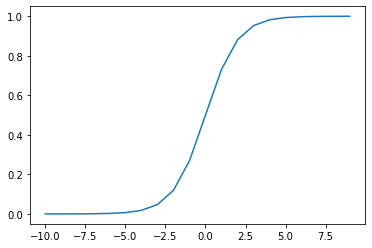

In [4]:
# TEST YOUR CODE
x = np.arange(-10,10,1)
y = sigmoid(x)
plt.plot(x,y); plt.show(); plt.close()

Recall that the cross entropy loss is defined as:
$$
R(\wb) = -\sum_i (y_i \log(\hat{y}(\xb_i)) + (1-y_i)\log(1-\hat{y}(\xb_i))) $$

Let's code it using NumPy. If you do it correctly, it can be written in one line!

In [5]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """    
    return -np.sum(labels * np.log(sigmoid(data @ w)) + (1 - labels) * np.log(1 - sigmoid(data @ w)))

In [6]:
# TEST YOUR CODE
utest_data = np.random.normal(size=(100,5))
utest_labels = np.random.binomial(n=1,p=0.5,size=100)
utest_w = np.random.normal(size=(5,))
utest_loss = loss_logistic(utest_data, utest_labels, utest_w)
print(utest_loss)

94.68251932704264


To move the weight vector towards the optimal weights, we need to compute the gradient of the loss function. This gradient is defined as
$$\nabla R(\wb)= \sum_i (\hat{y}(\xb_i) - y_i)\xb_i $$
Let us put this into a nice matrix format:
$$\nabla R(\wb)= \Xb^\top(\hat{y}(\Xb) - \yb) = \Xb^\top(\sigma(\Xb\cdot \wb) - \yb),
$$

where $\hat{y}(\Xb) = \sigma(\Xb\cdot \wb)$ and $\sigma(\Xb\cdot \wb)$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.

Fill in the function for computing the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [7]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        grad (np. array): Gradient array of shape (D, )
    """
    return data.T.dot(sigmoid(data.dot(w))-labels)

In [8]:
# TEST YOUR CODE
utest_grad = gradient_logistic(utest_data, utest_labels, utest_w)
print(utest_grad)

[  1.30101296  19.31801517  22.76784752 -19.90169536   4.87058368]


## 2.2 Classifying using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training to predict the labels for the data.

**Hints:**
* We classify our data according to $P(y_i=1|\xb_i, \wb)$. If the value of $P(y_i=1|\xb_i, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [9]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        predictions (np.array): Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold.
    predictions = sigmoid(data@w)
    predictions[predictions<0.5]=0
    predictions[predictions>=0.5]=1        
    return predictions

In [10]:
utest_pred = logistic_regression_classify(utest_data, utest_w)
print(utest_pred)

[0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1.]


We measure the performance of our classifier with *accuracy* metric. It is defined as $$ f_{\text{acc}} = \frac{\text{\# correct predictions}}{ \text{\# all predictions}}$$
Implement the following `accuracy_fn()` function using the predicted and ground truth labels.

In [11]:
def accuracy_fn(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        acc (float): Accuracy, in range [0, 1].
    """
    return np.sum(labels_gt == labels_pred) / labels_gt.shape[0]

In [12]:
utest_labels1 = np.random.binomial(n=1,p=0.5,size=10)
utest_labels2 = np.random.binomial(n=1,p=0.5,size=10)                
utest_acc = accuracy_fn(utest_labels1, utest_labels2)
print(utest_acc)

0.6


## 2.3 Training a logistic regression model

To find the optimal weights for the given training data, we need to train our model. Fill in the missing parts of the function `logistic_regression_train()`.

The function first initializes the weights randomly (according to a Gaussian distribution). In each iteration, you should compute the gradient using `gradient_logistic` and take a gradient step to update the weights. Given that $\eta$ is the learning rate, recall that a gradient step is expressed as: $$ \wb_{[t + 1]}  = \wb_{[t]} - \eta \nabla R(\wb_{[t]}) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.



In [13]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=1000, plot_period=1000):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np.array: weights of shape(D, )
    """

    #initialize the weights randomly according to a Gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data, labels, weights)
        weights = weights - lr*gradient
        ##################################
        
        # if we reach 100% accuracy, we can stop training immediately
        predictions = logistic_regression_classify(data, weights)
        if accuracy_fn(labels, predictions) == 1:
            break
        # logging
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic(data, labels, weights))
        # plotting
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions, title="iteration "+ str(it))
        
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions, title="final model")
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

loss at iteration 0 : 73.75025913824173


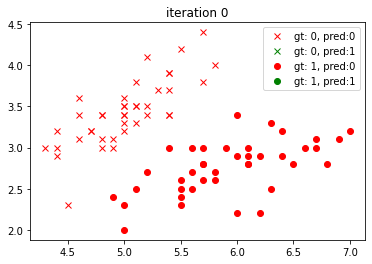

loss at iteration 1000 : 3.9672628784707205
loss at iteration 2000 : 3.4549944056654205
loss at iteration 3000 : 3.063881006724872


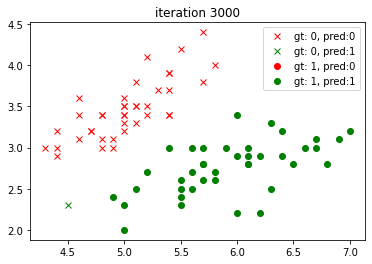

loss at iteration 4000 : 2.7456783349913767
loss at iteration 5000 : 2.4833039903351697
loss at iteration 6000 : 2.2653468524302207


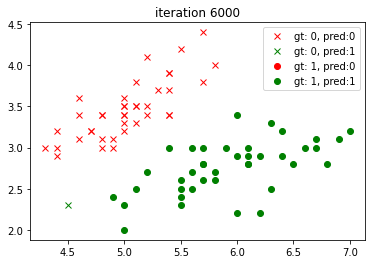

loss at iteration 7000 : 2.0827471516497784
loss at iteration 8000 : 1.9282687118190145
loss at iteration 9000 : 1.7962359852157859


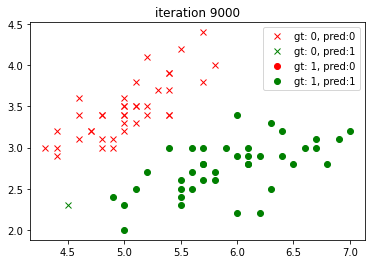

loss at iteration 10000 : 1.682248574186416
loss at iteration 11000 : 1.58290371791861
loss at iteration 12000 : 1.495560695472013


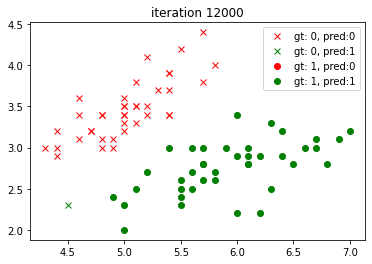

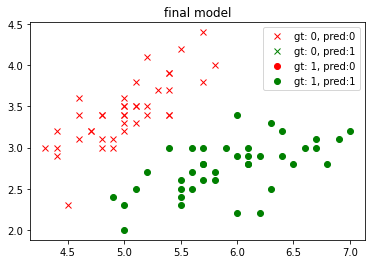

In [14]:
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=3000)

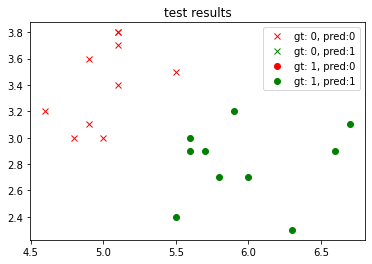

Accuracy is 1.0


In [15]:
predictions = logistic_regression_classify(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions, title="test results")
print("Accuracy is", accuracy_fn(labels_test, predictions))

Now that we have classified two classes, we can move on to multi-class logistic regression!

# 3 Multi-Class Logistic Regression

Load the synthetic data by running the code segment below. We will use this dataset for now as it is easy to work with.
Our data is:

 - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features + the bias)
 - labels: $\Yb \in \real^{N \times C}$, $\forall \yb_i \in \Yb: \yb_i$  is a one-hot encoding of the label of a data sample, e.g. $\yb_i = [0, 0, 1]$ if $\xb_i$ is class $2$. $C$ is number of classes.

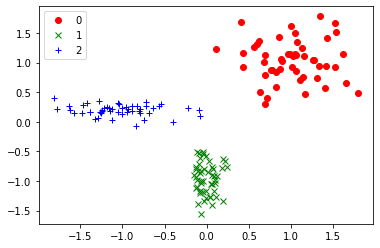

In [16]:
data_multi, labels_multi = helpers.load_dataset_synth(addbias=True)
fig = helpers.scatter2d_multiclass(data_multi, helpers.onehot_to_label(labels_multi), fig=None, fig_size=None, color_map=None,
                         legend=True, legend_map=None, grid=False, show=False)

num_samples = data_multi.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)
data_train = data_multi[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels_multi[rinds[:int(num_samples * fraction_train)]]  

data_test = data_multi[rinds[int(num_samples * fraction_train):]] 
labels_test= labels_multi[rinds[int(num_samples * fraction_train):]]  

## 3.1 A short introduction 

Multi class logistic regression is an extension to binary logistic regression.

Let us consider logistic regression for C classes. We keep our weights in a weight matrix $\mathbf{W}$, where every column is $\wb_{(k)}$ for class $k$. Therefore, for every class $k$, we learn a separate $\wb_{(k)}$ during training. The weights matrix will be of size $(3 \times C)$.

The generalized probabilities for logistic regression is
$$\hat{y}^{(k)}(\xb_i) = P(y_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{\sum_j^C e^{\xb_i^\top\cdot \wb_{(j)}}}$$ 
which is called the softmax function! Let us denote this function by $f_\text{softmax}$.

Fill in the implementation of this function below. It is used to assign the probabilities of a datapoint belonging to each class. For example, for a single datapoint, for 3 classes you might have the following probability assignments {0.2, 0.7, 0.1}. The probabilities all sum up to 1. 



In [17]:
def f_softmax(data, w):
    """ Softmax function
    
    Args:
        data (np.array): Input data of shape (N, D)
        w (np.array): Weights of shape (D, C) where C is # of classes
        
    Returns:
        res (np.array): Probabilites of shape (N, C), where each value is in 
            range [0, 1] and each row sums to 1.
    """
    
    # We've left this part for you to code for your projects.
    return res

In [18]:
# TEST YOUR CODE
utest_data = np.random.normal(size=(100,5))
utest_w = np.random.normal(size=(5,5))
utest_softmax = f_softmax(utest_data, utest_w)
print(utest_softmax.shape)

(100, 5)


Using these, we find the loss function which we are trying to minimize is

$$R(\mathbf{W}) = -\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(\hat{y}^{(k)}(\xb_i)) \\
=-\sum_{i}^N\sum_{k}^Cy_i^{(k)}\log(f_\text{softmax}(\xb_{i}^\top \cdot \wb_{(k)}))$$ 

Fill in the loss function below.

In [19]:
def loss_logistic_multi(data, labels, w):
    """ Loss function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, C) (in one-hot representation)
        w (np.array): Weights of shape (D, C)
        
    Returns:
        float: Loss value 
    """
    # We've left this part for you to code for your projects.
    return loss

In [20]:
# TEST YOUR CODE
utest_labels = helpers.label_to_onehot(np.random.binomial(n=4,p=0.5,size=100))
utest_loss = loss_logistic_multi(utest_data, utest_labels, utest_w)
print(utest_loss)

248.75770920468733


To find the gradient, we find the gradient of $R(\mathbf{W})$ with respect to the weights $\wb$. We have
$$\nabla R(\mathbf{W})=\sum_i^N\xb_{i}(\hat{\yb}(\xb_i)-y_i)^\top$$
Let's put this into matrix format as well:
$$\nabla R(\mathbf{W})= \Xb^T(\hat{\yb}(\Xb) - \Yb)$$

A note on the notation:
Here, $\hat{\yb}(\xb_i)$ returns the softmax result of shape $(C \times 1)$ for sample $\xb_i$ for all classes. 

$\hat{\yb}(\Xb)$ should return a matrix of shape $(N\times C)$, which consists of the softmax predictions for every sample for all classes. (Each row of $\hat{\yb}(\Xb)$ is $\hat{\yb}(\xb_i)$.)


Now, you will fill in the gradient function, `gradient_logistic_multi()` given below. 



In [21]:
def gradient_logistic_multi(data, labels, w):
    """ Gradient function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, )
        w (np.array): Weights of shape (D, C)
        
    Returns:
        grad_w (np.array): Gradients of shape (D, C)
    """
    # We've left this part for you to code for your projects.
    return grad_w

In [22]:
utest_grad = gradient_logistic_multi(utest_data, utest_labels, utest_w)
print(utest_grad.shape, "\n", utest_grad)

(5, 5) 
 [[  2.20222894  -0.94916253   3.71135731   5.04884602 -10.01326974]
 [ -8.58040725  -3.78401769   7.61065717  10.6299113   -5.87614352]
 [ -4.94433322  16.23096745  -1.98501946  10.59517337 -19.89678814]
 [ -4.15771597   5.93245466  -0.23573775 -22.86557415  21.32657321]
 [  0.8626542    9.72256603 -12.41776245  -1.9420283    3.77457052]]


## 3.2 Classification and training for multiple classes

Write the functions for classification and training.

Hints:
* For the classification function, you will be using $f_\text{softmax}$ to assign the probabilities of a datapoint belonging to each class. The softmax function returns an array of size $(N \times C)$.
* You will have to convert one-hot representation to labels (`np.argmax` is your friend). 

* Training will be the same as the binary case. First, we will find the gradient. Then we will update the weights using gradient descent.

In [23]:
def logistic_regression_classify_multi(data, w):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, C)
    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    #### write your code here: find predictions, argmax to find the correct label
    # We've left this part for you to code for your projects.
    return predictions

In [24]:
def logistic_regression_train_multi(data, labels, k=3, max_iters=10, lr=0.001, 
                                    print_period=5, plot_period=5):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, C)
        k (integer): Number of classes. Default=3
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.

    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    weights = np.random.normal(0, 0.1, [data.shape[1], k])
    for it in range(max_iters):
        # YOUR CODE HERE
        gradient = gradient_logistic_multi(data, labels, weights)
        weights = weights - lr*gradient
        ##################################
        predictions = logistic_regression_classify_multi(data, weights)
        if accuracy_fn(helpers.onehot_to_label(labels), predictions) == 1:
            break
        #logging and plotting
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic_multi(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions, title="iteration "+ str(it))
    fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions, title="final model")
    return weights

loss at iteration 0 : 127.49453368189606


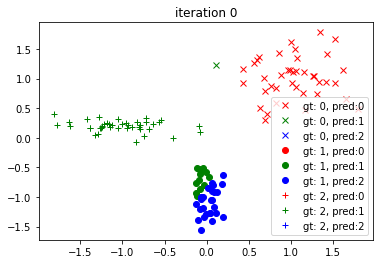

loss at iteration 5 : 101.96376333327282


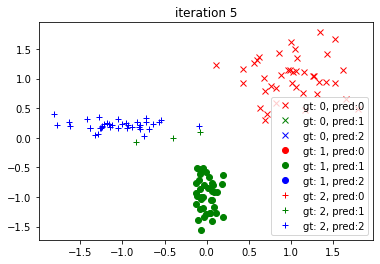

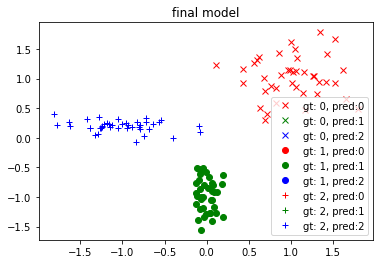

In [25]:
weights_multi = logistic_regression_train_multi(data_train, labels_train, max_iters=20, lr=1e-3, print_period=5, plot_period=5)

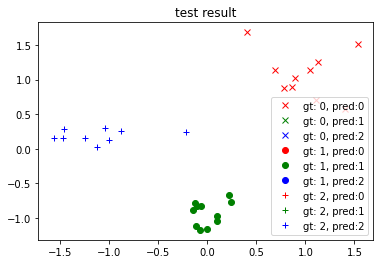

Accuracy is 1.0


In [26]:
predictions_multi = logistic_regression_classify_multi(data_test, weights_multi)
fig = helpers.visualize_predictions(data=data_test, labels_gt=helpers.onehot_to_label(labels_test), labels_pred=predictions_multi, title="test result")
print("Accuracy is", accuracy_fn(helpers.onehot_to_label(labels_test), predictions_multi))

**An (optional) side note:** Notice that using this simple formulation, we have trained C classifiers for C classes.
Our probability assignments are according to the softmax function.
$$P(\yb_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{\sum_j^C e^{\xb_i^\top\cdot \wb_{(j)}}}$$
And $$\sum_{k}^{C}P(\yb_i=k|\xb_i, \mathbf{W})=1$$
However, in the binary case we were training 1 classifier for 2 classes. The probabilities are assigned according to the sigmoid function.
$$P(\yb_i=1|\xb_i, \wb) = \frac{1}{1+e^{-(\xb_i^\top\cdot \wb)}} \\
P(\yb_i=0|\xb_i, \wb) = 1-P(\yb_i=1|\xb_i, \wb) = \frac{1}{1+e^{(\xb_i^\top\cdot \wb)}}$$

Similar to the binary case, we can train C-1 classifiers for C classes. We modify the probability assignment function to be, for classes $k={1, ... ,C-1}$.
$$P(\yb_i=k|\xb_i, \mathbf{W}) = \frac{e^{\xb_i^\top\cdot \wb_{(k)}}}{1+\sum_j^{C-1} e^{\xb_i^\top\cdot \wb_{(j)}}}$$

**Q (optional): What is $P(\yb_n=C|\xb_i, \mathbf{W})$?**
$$P(\yb_n=C|\xb_i, \mathbf{W}) = 1- \sum_{k}^{C-1}P(\yb_i=k|\xb_i, \mathbf{W})\\
1- \sum_{k}^{C-1}\frac{e^{\xb_i^T\cdot \wb_{(k)}}}{1+\sum_j^{C-1} e^{\xb_i^T\cdot \wb_{(j)}}} = 1-\frac{\sum_{k}^{C-1}e^{\xb_i^T\cdot \wb_{(k)}}}{1+\sum_j^{C-1} e^{\xb_i^T\cdot \wb_{(j)}}}\\
P(\yb_i=C|\xb_i, \mathbf{W}) = \frac{1}{1+\sum_j^{C-1} e^{\xb_i^\top\cdot \wb_{(j)}}}$$

Further reading: https://en.wikipedia.org/wiki/Multinomial_logistic_regression